In this notebook we will be looking at the 'Communities and Crime' dataset found in the UC Irvine Machine Learning Repository.

The data has demographic data from the 1990 Census and Crime
data from the 1995 FBI UCR. All of the values in the dataset are normalized. This means that instead of directly saying what the value is the number is scaled from 0 to 1 by divinding by the max value for that variable. For example, if a town has a population of 10 people and the max population is 100 people, this town would be given a value of .1 for population. 

Our goals are 2 fold
1. Find trends in the demographic data. Questions of interest are what is the percentage of people in the U.S by race? What is the distribution of incomes? 
2. Are there certain variables in particular that lead to crime? Can we create a model for this? 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

First let's import the data. I downloaded the file with the columns to my local machine and will directly use the url to get the data

In [2]:
with open("cols.txt") as file:
    columns = [line.strip() for line in file]

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data',
                 header = None , names= columns)

In [4]:
df.shape

(1994, 128)

There are over 128 columns which is too much to start with. Let's try choosing the most important columns. A good column to one that has any of these
1. Is related to Crime
2. Helps characterize our data
3. Is not overly specific since a specific variable may be related to other variables in our dataset

Note that the data file provided on the dataset contains a data dictionary which notes several columns that should not be used for analysis but only background info. 

In [112]:
wantedFeatures = ['state', 'population', 'racePctWhite', 'racepctblack', 'racePctAsian',
'racePctHisp','agePct12t21','agePct12t29','agePct16t24',
'agePct65up','medIncome', 'PctPopUnderPov', 'PctUnemployed','PctLargHouseFam'
,'PolicPerPop', 'PolicBudgPerPop', 'ViolentCrimesPerPop']

df_c = df[wantedFeatures]

The columns are...
1. state - a numerical code for each state. 
2. population - the number of people living in the town.
3. racePctWhite - the percentage of white people.
4. racepctblack - the percentage of black people.
5. racePctAsian - the percentage of Asian
6. agePct12t21 -  the percentage of people between 12 and 21
7. agePct12t29 -  the percentage of people between 12 and 29
8. agePct16t24 -  the percentage of people between 16 and 24
9. agePct65up -  the percentage of people above 65
10. medIncome - the median income
11. PctPopUnderPov - the percentage of population under poverty
12. PctUnemployed - the percentage of people unemployed
13. PctLargHouseFam - the percentage of households with > 6 people
14. PolicPerPop - the police per population
15. PolicBudgPerPop - the budget per population
16. ViolentCrimesPerPop - the violent crimes per pop. (This will be our target variable) 

First we should expore our data a bit. 
We should first question is our dataset representative of the population?

A starting point is to look at the state field. How many states are we using and are the columns around equally distributed based on the states size?

In [6]:
df_c.state.isnull().any()

False

We have no nulls which is a good first step.

In [7]:
state_count = df_c['state'].value_counts()

The state field gives the number state and the value for each one. It is unclear from the dataset which number corresponds to what state so we will need to do some exploring.

In [8]:
state_count.shape

(46,)

We have 46 of the 50 states which is pretty good. 

In [9]:
state_count.head(10)

6     278
34    211
48    156
25    121
39    109
42    101
12     90
9      69
55     60
18     48
Name: state, dtype: int64

In [10]:
state_count.tail(10)

38    8
16    7
56    7
27    7
32    5
50    4
2     3
10    1
11    1
20    1
Name: state, dtype: int64

We see that some states we have a lot of records for and others we have few.This is expected though since certain states are bigger than others. 

Let's validate that the top few are large states and botumn few are small. We could do this since we have the communityname in our dataset and we can use google to match the community with the state.

In [11]:
state_20 = df[df['state'] == 20]

In [12]:
state_20['communityname']

557    Wichitacity
Name: communityname, dtype: object

Wichita Cityis in Kansas. In the 1990 census Kansas ranked 32nd in population. It is a bit surprising that there is only 1. 

In [13]:
state_11 = df[df['state'] == 11]

In [14]:
state_11['communityname']

1044    Washingtoncity
Name: communityname, dtype: object

Washington City is in Utah. They ranked 35th in population in the 1990 election. This is similar to Kansas. 

In [15]:
state_6 = df[df['state'] == 6]

In [16]:
state_6['communityname'].head()

5     SouthPasadenacity
7             Selmacity
10         DalyCitycity
14        DanaPointcity
20          Modestocity
Name: communityname, dtype: object

These are all comunities in California. California is a large state so it makes sense that we have a lot of records from them.

In [17]:
state_34 = df[df['state'] == 34]

In [18]:
state_34['communityname'].head()

3         Willingborotownship
17           Denvilletownship
39         Plainsborotownship
40    LittleEggHarbortownship
44             Paramusborough
Name: communityname, dtype: object

These are all NJ towns. NJ ranked 9th in the U.S. census in 1990 so it makes sense that these rows will be by the top.

<hr>

We can conclude from this that our sample is fairly representative of the U.S. Certain states have lots more rows than others and a lot have under 30 records. Because of this we shouldn't use this data to compare crime by states. However, we still can use this analysis to more credibly assume we have a random sample. 

<hr>

### Characteristics of U.S population

Let's look at the distributions of some of the columns in our dataset. First population. One question we have to ask is is the data from this dataset which is from the 1990's still relevant?

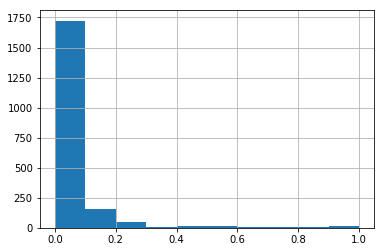

In [46]:
df_c.population.hist()

We see that we don't have actual values for population but rather they were normalized on a scale from 0 to 1. This distribution is right skewed which logically makes sense. Some neighborhoods are going to have a lot more residents than other cities. We need to keep this in mind if we use this field later since we have very few records with values > .4 just because of how the data was normalized.

Let's plot the avg race percentages

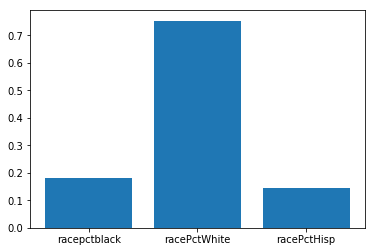

In [47]:
x = ['racepctblack', 'racePctWhite', 'racePctHisp']
y = [df_c[x[0]].mean(), df_c[x[1]].mean(), df_c[x[-1]].mean()]

plt.bar(x,y)
plt.show()

We see that most people in this study were white. 

One question we might ask is, is this representative of the population today? We can do a chi square goodness of fit test. 

The null hypothesis is that the values match the expected values. 
The alternate is that the vaues don't match the expected values.

Under the null hypothesis, we find on  https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_16_1YR_CP05&prodType=table
that the expected percentage of whites is 72.6, black 12.7, hispanic 17.8.

In [48]:
tmp = [(y[0] - .127)**2/.127, (y[1] - .726)**2/.726, (y[2] - .178)**2/.178 ]
tmp

[0.021809446543849545, 0.0010581059017138277, 0.006485954974228266]

In [49]:
import math
math.fsum(tmp)

0.02935350741979164

So our chi square value is .029. Our df is 2 since we have 3 categories.

In [50]:
from scipy import stats

In [51]:
1- stats.chi2.cdf(.029, 2)

0.9856046187323824

Just to confirm I found a method while doing this that can do this all in one step

In [52]:
scipy.stats.chisquare(y, [.127, .726, .178])

Power_divergenceResult(statistic=0.02935350741979164, pvalue=0.9854304248546916)

With a pvalue so high we see that the current races in America are not so different than the ones we have now. Because of this, we fail to reject the null hypothesis and the data in the study is still relevant.

Now let's look at ages

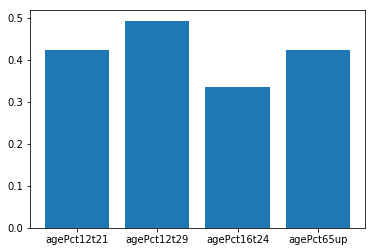

In [243]:
x = ['agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up']
y = [df_c[x[0]].mean(), df_c[x[1]].mean(), df_c[x[2]].mean(), df_c[x[-1]].mean() ]

plt.bar(x,y)
plt.show()

The age brackets seem uniform. It's going to be hard to use this variable because of how these age brackets overlap. Also these numbers don't seem very meaningfull. 

Now let's look at income. The income columns were also normalized. 

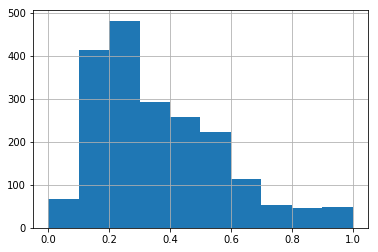

In [53]:
df_c['medIncome'].hist()

The incomes are also right skewed. 

In [54]:
df_c.medIncome.describe()

count    1994.000000
mean        0.361123
std         0.209362
min         0.000000
25%         0.200000
50%         0.320000
75%         0.490000
max         1.000000
Name: medIncome, dtype: float64

The mean is .3611 and the deviation is .20
This is quite a large deviation. 

Next let's look at crime, our target variable. 

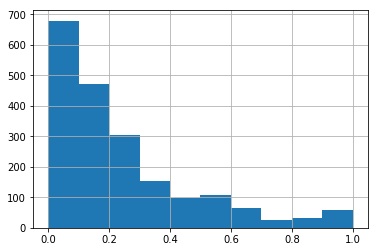

In [55]:
df_c.ViolentCrimesPerPop.hist()

This also is right skewed. This makes sense since the neighborhoods that have a lot of crime would heavily outweigh the ones that have less

In [56]:
df_c.ViolentCrimesPerPop.describe()

count    1994.000000
mean        0.237979
std         0.232985
min         0.000000
25%         0.070000
50%         0.150000
75%         0.330000
max         1.000000
Name: ViolentCrimesPerPop, dtype: float64

This distribution looks strikingly similar to our distribution of median income. Let's try to see if there is any correlation

In [57]:
import seaborn as sns

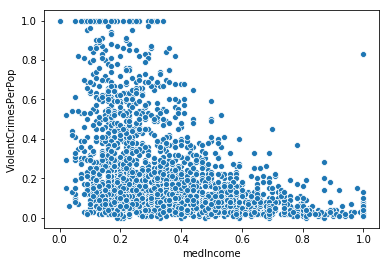

In [58]:
X = df_c.medIncome
y = df_c.ViolentCrimesPerPop
sns.scatterplot(df_c.medIncome, df_c.ViolentCrimesPerPop)


It seems from this graph that the lower the income the more crime. In particular we can see that all the high crimes (>.8) have a medIncome under .5. This relationship doesn't appear to be linear. We could try to create a line for it that we could use to make predictions based on the violentcrimesperpop. 

This doesn't appear to be linear but we could start with one to see if there at least is a relationship

In [59]:
from scipy import stats

In [60]:
slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
print("slope: %f intercept: %f" % (slope, intercept))

slope: -0.472085 intercept: 0.408460


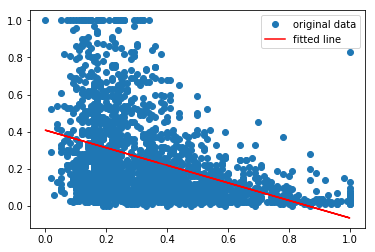

In [61]:
plt.plot(X, y, 'o', label='original data')
plt.plot(X, intercept + slope*X, 'r', label='fitted line')
plt.legend()
plt.show()

We see that the slope is -.472. This shows that we have a negative relationship. The slope is minimizing the square of the distance to the line. 

In [62]:
p_value

6.334424808053117e-88

Our p value is low which shows there is a significant relationship.

In [63]:
r_value

-0.42422061672612604

Our r^2 value also is negative which shows a negative relationship. This number shows how much of the variance our model explains. The number show the stregnth of the relationship is around medium; not overly strong, but not overly weak. This is because we can see that the variance for low income is very high. We can also try using an exponential and polynomial equation since the line seems to come up sharply when income goes down. 

In [66]:
import scipy 
import numpy as np
def exponential(x, a, k, b):
    return a*np.exp(x*k) + b

In [67]:
exp_vars= scipy.optimize.curve_fit(exponential, X, y, p0=[.5,-0.3, 1])[0]
exp_vars


array([ 0.58207994, -1.65437962, -0.09998593])

In [68]:
points = []
for i in X:
    val = exponential(i,exp_vars[0], exp_vars[1],exp_vars[2])
    points.append(val)

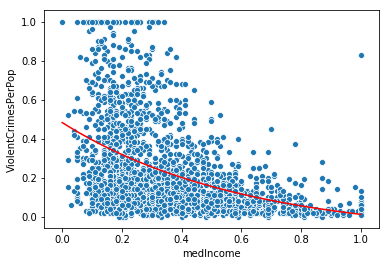

In [69]:
sns.lineplot(X,points, color = 'r')
sns.scatterplot(X,y)

This graph still seems on sight to be accurate. We see for example, how at medIncome = .2, around half the points are below and half are above. Let's see if a polynomial graph would give a similar result. 

In [70]:
import numpy as np
poly = np.poly1d(np.polyfit(X, y, 2))
poly

poly1d([ 0.44631903, -0.8825207 ,  0.47891974])

the points above are the coefs of our parabola.

In [71]:
myline = np.linspace(0, 1, 100)

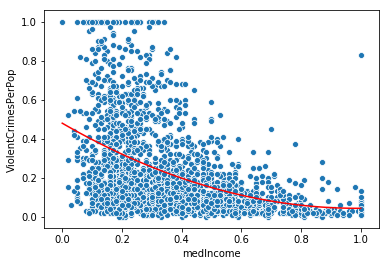

In [72]:
plt.plot(myline, poly(myline), color = 'r')
sns.scatterplot(X,y)

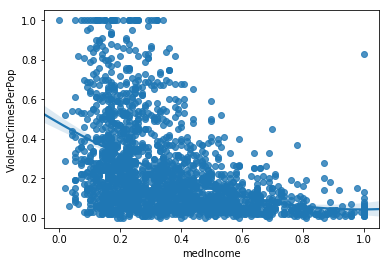

In [73]:
sns.regplot(X,y, order = 2)

Let's regroup and incorporate more variables

In [80]:
import statsmodels.api as sm
df_c = df_c.replace('?',np.nan)
df_c = df_c.dropna()
#model = sm.OLS(y=df_c['ViolentCrimesPerPop'], x=[df_c['medIncome']])
y_m= df_c['ViolentCrimesPerPop']
x_m = df_c[['medIncome', 'population', 'agePct65up', 'PolicPerPop', 'PctUnemployed', 'PctLargHouseFam', 'racepctblack']]
model = sm.OLS(y_m, x_m.astype(float)).fit()
predictions = model.predict(x_m.astype(float))

It's hard to visualize the model now that we are incorporating more than 1 variable but we can show it against the same variable as we did before. 

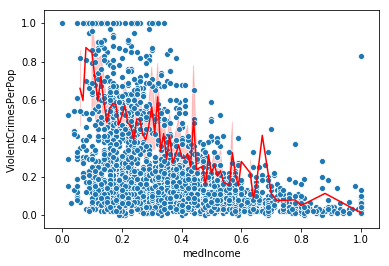

In [81]:
sns.lineplot(X,predictions, color = 'r')
sns.scatterplot(X,y)

In [82]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.881
Model:                             OLS   Adj. R-squared:                  0.878
Method:                  Least Squares   F-statistic:                     328.4
Date:                 Sun, 22 Mar 2020   Prob (F-statistic):          7.94e-140
Time:                         18:25:40   Log-Likelihood:                 94.599
No. Observations:                  319   AIC:                            -175.2
Df Residuals:                      312   BIC:                            -148.8
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
medIncome          -0.1880      0.061     -3.098      0.002      -0.307      -0.069
population          0.2169      0.043      5.068      0.000       0.133       0.301
agePct65up          0.2182      0.068      3.198      0.002       0.084       0.352
PolicPerPop         0.1027      0.070      1.476      0.141      -0.034       0.239
PctUnemployed       0.1933      0.078      2.468      0.014       0.039       0.347
PctLargHouseFam     0.3200      0.073      4.359      0.000       0.176       0.464
racepctblack        0.4143      0.039     10.540      0.000       0.337       0.492
==============================================================================
Omnibus:                       13.521   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.083
Skew:                           0.505   Prob(JB):                     0.000875
Kurtosis:                       3.202   Cond. No.                         10.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Some observations:
1. Our Adjusted r2 value is very close to our real r2 value. This tells us that our variables are adding meaning. 
2. The coef tells us how much that variable is contributing to y. For example, if the percentage of blacks is high, the pct of crime goes up by .4143. 
2. Most of the variables have a very low p value. If we set a 5 percent signiicance evels, the only variables above this level is policeperpop. We could remake the model, this time excluding this variable. 

In [83]:
import statsmodels.api as sm
y_m= df_c['ViolentCrimesPerPop']
x_m = df_c[['medIncome', 'population', 'agePct65up', 'PctUnemployed', 'PctLargHouseFam', 'racepctblack']]
model = sm.OLS(y_m, x_m.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.880
Model:                             OLS   Adj. R-squared:                  0.877
Method:                  Least Squares   F-statistic:                     381.4
Date:                 Sun, 22 Mar 2020   Prob (F-statistic):          1.15e-140
Time:                         18:26:02   Log-Likelihood:                 93.488
No. Observations:                  319   AIC:                            -175.0
Df Residuals:                      313   BIC:                            -152.4
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
medIncome          -0.1816      0.061     -2.994      0.003      -0.301      -0.062
population          0.2136      0.043      4.988      0.000       0.129       0.298
agePct65up          0.2594      0.062      4.161      0.000       0.137       0.382
PctUnemployed       0.1837      0.078      2.349      0.019       0.030       0.338
PctLargHouseFam     0.3291      0.073      4.489      0.000       0.185       0.473
racepctblack        0.4294      0.038     11.296      0.000       0.355       0.504
==============================================================================
Omnibus:                       13.190   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.776
Skew:                           0.504   Prob(JB):                      0.00102
Kurtosis:                       3.145   Cond. No.                         9.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This didn't change our model so much. We could continue eliminating the least significant variables 1 at a time but all our p values are below the 5 percent significant level showing that the probability that the chance that the coeficent is 0 and there is no relationship is very low for all of these variables. 

We could use these coeficents to help see what causes crime. 

1. Higher incomes have less crime
2. Higher populations have more crimes
3. Larger families have more crimes
4. Areas with lots of blacks have more crimes. This is the most significant with a coeficent of .4294. 

We should ask though if some of our variables in our model are related. If they are we might consider taking one out of the model.

In [105]:
cols = ['medIncome', 'population', 'agePct65up', 'PctUnemployed', 'PctLargHouseFam', 'racepctblack']

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        print('The pearson, p values value for ' + cols[i] + ', ' + cols[j] + ' are...')
        print(stats.pearsonr(df_c[cols[i]], df_c[cols[j]]))


The pearson, p values value for medIncome, population are...
(-0.16743310459372013, 0.0027005360575177704)
The pearson, p values value for medIncome, agePct65up are...
(-0.107668668888606, 0.054723785409352056)
The pearson, p values value for medIncome, PctUnemployed are...
(-0.6522865471202367, 4.84113831439168e-40)
The pearson, p values value for medIncome, PctLargHouseFam are...
(-0.181944715024456, 0.001097865569238197)
The pearson, p values value for medIncome, racepctblack are...
(-0.4676391859487752, 9.755374716811963e-19)
The pearson, p values value for population, agePct65up are...
(-0.2179545402464745, 8.68027753103463e-05)
The pearson, p values value for population, PctUnemployed are...
(0.1343731426908356, 0.016329770142160496)
The pearson, p values value for population, PctLargHouseFam are...
(0.22047448413086157, 7.147610049180148e-05)
The pearson, p values value for population, racepctblack are...
(0.17394831161618385, 0.0018181895022918212)
The pearson, p values value f

We notice that we do have some variables that are correlated. The low p values shows these are unlikely to occur purely due to chance. We should eliminate the ones with very high relationships because we can't trust our coeficents with the model as it is now. This means we also can't trust the p values from our model. 

First let's get rid of pct unemployed. We see it has a high correlation with almost all of our variables. 

In [106]:
import statsmodels.api as sm
y_m= df_c['ViolentCrimesPerPop']
x_m = df_c[['medIncome', 'population', 'agePct65up', 'PctLargHouseFam', 'racepctblack']]
model = sm.OLS(y_m, x_m.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.878
Model:                             OLS   Adj. R-squared:                  0.876
Method:                  Least Squares   F-statistic:                     450.1
Date:                 Tue, 24 Mar 2020   Prob (F-statistic):          7.91e-141
Time:                         22:02:50   Log-Likelihood:                 90.701
No. Observations:                  319   AIC:                            -171.4
Df Residuals:                      314   BIC:                            -152.6
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
medIncome          -0.2284      0.058     -3.960      0.000      -0.342      -0.115
population          0.2192      0.043      5.090      0.000       0.134       0.304
agePct65up          0.3527      0.048      7.285      0.000       0.257       0.448
PctLargHouseFam     0.4577      0.049      9.325      0.000       0.361       0.554
racepctblack        0.4616      0.036     12.927      0.000       0.391       0.532
==============================================================================
Omnibus:                       11.063   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.428
Skew:                           0.462   Prob(JB):                      0.00330
Kurtosis:                       3.078   Cond. No.                         5.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

By removing pct unemployed from our model, our coeficents are now more in line with how much they actually are affecting the model. Our adjusted r2 value is less but insignificantly. This isn't to say that pct unemployed is insignificant; it's just 'covered' by the other variables in our model. To illustrate we could probably make a good prediction of pct unemployed from the other variables, dropping population which had a low correlation. 

In [465]:
import statsmodels.api as sm
y_m= df_c['PctUnemployed']
x_m = df_c[['medIncome', 'agePct65up', 'PctLargHouseFam', 'racepctblack']]
model = sm.OLS(y_m, x_m.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          PctUnemployed   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     1003.
Date:                Tue, 24 Mar 2020   Prob (F-statistic):          9.29e-178
Time:                        23:18:48   Log-Likelihood:                 196.61
No. Observations:                 319   AIC:                            -385.2
Df Residuals:                     315   BIC:                            -370.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
medIncome          -0.2516      0.041     -6.109      0.000      -0.333      -0.171
agePct65up          0.5090      0.035     14.687      0.000       0.441       0.577
PctLargHouseFam     0.7104      0.034     21.172      0.000       0.644       0.776
racepctblack        0.1799      0.025      7.158      0.000       0.130       0.229
==============================================================================
Omnibus:                        1.936   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.380   Jarque-Bera (JB):                1.693
Skew:                           0.168   Prob(JB):                        0.429
Kurtosis:                       3.120   Cond. No.                         5.07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We have a very high r2 value of .927 and a very close adjusted r2 value at .926. This justifies why we should take it off of our model for violent crimes. It's repetitive with the other variables. 

We could turn this into a logistic regression problem as follows: Is their a high amount of crime (crime > .3 ) or not. 

In [487]:
highCrimes = df['ViolentCrimesPerPop'].map(lambda x: 1 if x > .3 else 0)
x = df[['medIncome', 'agePct65up', 'PctLargHouseFam', 'racepctblack']]

In [488]:
import statsmodels.api as sm
logit_model=sm.Logit(highCrimes,x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.395709
         Iterations 7
                           Results: Logit
Model:              Logit               Pseudo R-squared: 0.322      
Dependent Variable: ViolentCrimesPerPop AIC:              1586.0873  
Date:               2020-03-24 23:23    BIC:              1608.4789  
No. Observations:   1994                Log-Likelihood:   -789.04    
Df Model:           3                   LL-Null:          -1164.6    
Df Residuals:       1990                LLR p-value:      1.6866e-162
Converged:          1.0000              Scale:            1.0000     
No. Iterations:     7.0000                                           
----------------------------------------------------------------------
                  Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------------
medIncome        -5.8534    0.3685  -15.8845  0.0000  -6.5756  -5.1311
agePct65up  

All of our p values are ~0. We therefore know that it is unlikely for the coefs. to occur by chance. One observation is that here the median income plays a much more important role than it did in the regression model with a coef close to -6 compared to -.2 above.  Let's evaluate the accuracy. 

(array([711., 360., 249., 142., 109.,  92.,  82.,  69.,  75., 105.]),
 array([0.00153735, 0.10074505, 0.19995275, 0.29916044, 0.39836814,
        0.49757584, 0.59678354, 0.69599123, 0.79519893, 0.89440663,
        0.99361433]),
 <a list of 10 Patch objects>)

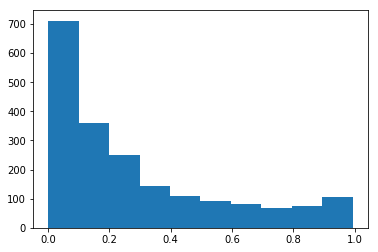

In [493]:
preds = result.predict(x)
s = np.sort(preds)
plt.hist(preds)

Our model predicts that most cities probably have a low crime rate which is consistant with the data. Also we see it isn't always choosing a low percentage which is important to note. Now to get an actual accuracy score... If the score is below .5 we say it would have made a prediction of a low crime rate and if above .5 it would have made a high rate.  

In [494]:
mappedPreds = preds.map(lambda x: 1 if x > .5 else 0)

In [498]:
import sklearn.metrics as met
met.accuracy_score(highCrimes, mappedPreds)

0.8189568706118355

Our accuracy score is ~82 percent which is decent. (not accounting for a training and test set)

Conclusions:
1. The distribution of income, population, and violent crimes are right skewed meaning that there are areas which have significantly more than other areas. 
2. The demographic data from the 1990 census is not statistically different than our current demographics.
2. Cities with large numbers of blacks, large families, and  large number of people above 65 have more crimes.